In [1]:
# !pip install "numpy<2"
# !pip install scipy
#!pip install finufft
# !pip install mrcfile
# !pip install matplotlib==3.7.5
# !pip install tqdm joblib
# !pip install torch --index-url https://download.pytorch.org/whl/cu118
# !pip install torch-harmonics

In [2]:
!joblib --version

/bin/bash: line 1: joblib: command not found


In [3]:
# !pip install torch_find_peaks

In [4]:
import torch_find_peaks

import torch
from torch_find_peaks import find_peaks_3d

In [5]:



t = torch.randn((64, 64, 64))
peaks = find_peaks_3d(t, threshold_abs=0, min_distance=3)

In [6]:
import sys
print("Executable:", sys.executable)
print("Version:", sys.version)

import torch
print("Torch:", torch.__version__)

Executable: /workspaces/fle3d-experiment1/.venv/bin/python
Version: 3.10.19 (main, Dec  9 2025, 02:10:15) [GCC 14.2.0]
Torch: 2.7.1+cpu


In [7]:
import sys, numpy
print(sys.executable)
print(sys.version)
print(numpy.__version__)

/workspaces/fle3d-experiment1/.venv/bin/python
3.10.19 (main, Dec  9 2025, 02:10:15) [GCC 14.2.0]
1.24.4


In [8]:
from fle_3d import FLEBasis3D

In [9]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch
from torch_find_peaks import find_peaks_3d, refine_peaks_3d

In [10]:
import numpy as np
import mrcfile
from fle_3d import FLEBasis3D
import matplotlib.pyplot as plt

In [11]:
import fle_3d
print(fle_3d.__file__)

/workspaces/fle3d-experiment1/fle_3d.py


In [12]:
# this loads the ball harmonics expansion -> we use it for rotation invariant volumes
# fle = FLEBasis3D(
#     N = 64,
#     bandlimit = 32,
#     eps = 1e-4)
# load volume


def get_rotation_invariant_volume(fle, volume):
    # forward transform
    coeffs = fle.evaluate_t(volume)

    # create placeholder for rotation invariant coefficients
    coeffs_tmp = np.zeros_like(coeffs)

    # for coefficients alpha_{k,l,m}, we only want l=m=0 terms
    # loop over all k indices
    for k in fle.idlm_list[0][0]:
        coeffs_tmp[k] = coeffs[k]

    # backward transform
    volume_ri = fle.evaluate(coeffs_tmp).real

    # return rotation invariant volume
    return volume_ri



In [13]:
# def get_rotation_invariant_volume(basis, volume):
#     coeffs = basis.evaluate_t(volume)
#     volume_ri = basis.evaluate(coeffs)
#     return volume_ri

In [14]:
# from isotropic_basis_3d import IsotropicBasis3D
# 
# fle = IsotropicBasis3D(
#     N=64,        # same N as before
# )

In [15]:
import importlib, fle_3d
print("Using:", fle_3d.__file__)
importlib.reload(fle_3d)
from fle_3d import FLEBasis3D
fle = FLEBasis3D(
    N = 64,
    bandlimit = 16,
    eps = 1e-4)

Using: /workspaces/fle3d-experiment1/fle_3d.py


Text(0.5, 1.0, 'Rotation invariant volume')

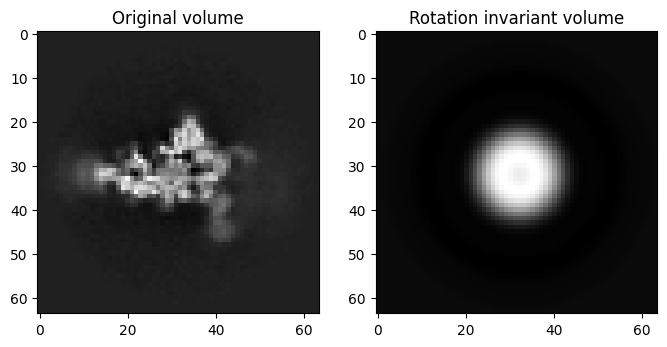

In [16]:

# this only a test volume, use mrcfile.open() for .mrc files
from scipy.io import loadmat
mat = loadmat('test_volumes/data_N=64.mat')["x"]

# get rotation invariant volume
mat_ri = get_rotation_invariant_volume(fle, mat)
temp_ri = get_rotation_invariant_volume(fle, mat)

# plot two volumes
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(mat[32], cmap='gray')
axs[0].set_title('Original volume')
axs[1].imshow(mat_ri[32], cmap='gray')
axs[1].set_title('Rotation invariant volume')

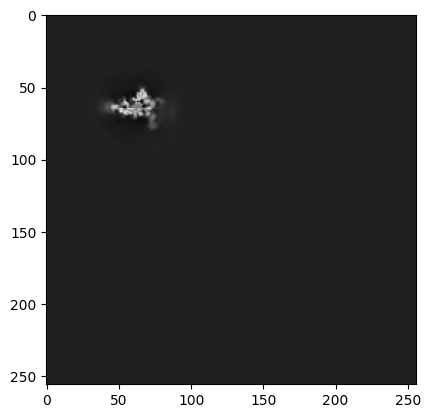

In [17]:
# get tomogram (via mrcfile.open())
# I use dummy volume

tomogram = np.zeros((256, 256, 256), dtype=np.float32)
tomogram[32:96, 32:96, 32:96] = mat
plt.imshow(tomogram[64], cmap='gray')


In [18]:
# Compute cross correlation between the two volumes
# numpy is easy to set up, faster will be something gpu accelerated like cupy or torch

def cross_correlation_3d(vol1, vol2):
    #return cross_correlation_values
    F1 = np.fft.fftn(vol1)
    F2 = np.fft.fftn(vol2)
    cc = np.fft.ifftn(F1 * np.conj(F2))
    cc= np.real(cc)
    return np.fft.ifftshift(cc)

# Then extract locations determined by peaks in the cross correlation volume
def extract_peak(cc):
    # return peak location
    peak = np.argmax(cc)
    idx = np.unravel_index(peak, cc.shape)
    center = np.array(cc.shape)//2
    displacement = np.array(idx)-center

    return idx, displacement, cc[idx]

# Check how well this works if you use the rotation invariant volume or the original volume as reference
# Check how this changes if you rotate the original volume first.


# After that: repeat this for the SHREC dataset. You have access to the correct tempplate.


In [19]:
def cross_correlation_3d(vol1, vol2):
    #return cross_correlation_values
    F1 = np.fft.fftn(vol1)
    F2 = np.fft.fftn(vol2)
    cc = np.fft.ifftn(F1 * np.conj(F2))
    cc= np.real(cc)
    return np.fft.ifftshift(cc)

In [20]:
cross_correlation_3d(temp_ri, mat)

array([[[0.1280173 , 0.12423183, 0.12527756, ..., 0.16831152,
         0.15008973, 0.13659734],
        [0.12883846, 0.12498515, 0.1259575 , ..., 0.16918476,
         0.15094497, 0.13749788],
        [0.13413604, 0.1300227 , 0.13086548, ..., 0.17559394,
         0.15695002, 0.14315054],
        ...,
        [0.15305192, 0.14829102, 0.14894129, ..., 0.19880808,
         0.17849372, 0.16318199],
        [0.13997771, 0.13573201, 0.13661633, ..., 0.1833406 ,
         0.16395109, 0.14943656],
        [0.13167703, 0.12775214, 0.12880049, ..., 0.17310722,
         0.15443839, 0.14054947]],

       [[0.13012863, 0.12660526, 0.12783891, ..., 0.16972693,
         0.15173872, 0.13848571],
        [0.13112624, 0.12751321, 0.12867735, ..., 0.17085466,
         0.15272681, 0.13951625],
        [0.13668459, 0.13273176, 0.13371796, ..., 0.17752499,
         0.15900387, 0.14544971],
        ...,
        [0.15494599, 0.15037724, 0.15122082, ..., 0.20023706,
         0.18007275, 0.16488083],
        [0.1

In [21]:
import torch
from torch_find_peaks import find_peaks_3d, refine_peaks_3d

In [22]:
# import pkg_resources
# pkg_resources.get_distribution("torch_harmonics").version

In [23]:
from torch_find_peaks import find_peaks_3d, refine_peaks_3d

def detect_peak_torch(cc, min_distance=3, threshold_abs=0.1, refine=True):
    cc_t = torch.tensor(cc, dtype=torch.float32)

    peaks_tuple = find_peaks_3d(
        cc_t,
        min_distance=min_distance,
        threshold_abs=threshold_abs,
        return_as="torch"
    )
    peaks = peaks_tuple[0] # Extract the peak locations tensor

    if peaks.shape[0] == 0:
        return None, None, None

    if refine:
        refined = refine_peaks_3d(
            cc_t,
            peaks,
            boxsize=8,
            max_iterations=200,
            tolerance=1e-6
        )
        best = refined[0].detach().cpu().numpy()
        amp, z, y, x, *_ = best
        return np.array([z, y, x]), amp, peaks_tuple[0].detach().cpu().numpy()

    # If not refining, still need to get the first peak from the locations tensor
    best = peaks[0].detach().cpu().numpy()
    z, y, x = best
    return np.array([z, y, x]), cc[int(z), int(y), int(x)], peaks_tuple[0].detach().cpu().numpy()

## baseline vs rotation-invariant comparison

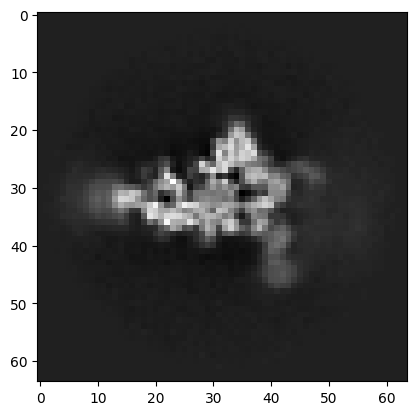

In [24]:
template = mat  # synthetic 64×64×64 test volume

angle = 45
rot = rotate(template, angle, axes=(1,2), reshape=False)

# baseline
cc_std = cross_correlation_3d(rot, template)
plt.imshow(template[32], cmap='gray')

In [25]:
cc_std.dtype

dtype('float64')

In [26]:
cc_t = torch.from_numpy(cc_std)
cc_t


tensor([[[0.0814, 0.0888, 0.1030,  ..., 0.0979, 0.0868, 0.0811],
         [0.0759, 0.0842, 0.0995,  ..., 0.0900, 0.0792, 0.0749],
         [0.0769, 0.0867, 0.1027,  ..., 0.0879, 0.0775, 0.0750],
         ...,
         [0.1344, 0.1385, 0.1495,  ..., 0.1609, 0.1459, 0.1367],
         [0.1103, 0.1155, 0.1282,  ..., 0.1341, 0.1202, 0.1121],
         [0.0929, 0.0990, 0.1125,  ..., 0.1139, 0.1007, 0.0934]],

        [[0.0823, 0.0903, 0.1053,  ..., 0.0978, 0.0864, 0.0807],
         [0.0760, 0.0847, 0.1008,  ..., 0.0878, 0.0771, 0.0728],
         [0.0759, 0.0862, 0.1020,  ..., 0.0829, 0.0741, 0.0716],
         ...,
         [0.1377, 0.1423, 0.1539,  ..., 0.1648, 0.1492, 0.1401],
         [0.1132, 0.1187, 0.1315,  ..., 0.1363, 0.1229, 0.1147],
         [0.0943, 0.1013, 0.1153,  ..., 0.1143, 0.1017, 0.0947]],

        [[0.0870, 0.0960, 0.1109,  ..., 0.0994, 0.0883, 0.0839],
         [0.0787, 0.0892, 0.1053,  ..., 0.0873, 0.0776, 0.0749],
         [0.0755, 0.0879, 0.1055,  ..., 0.0815, 0.0727, 0.

In [27]:
cc_std

array([[[0.08139129, 0.08879699, 0.10304436, ..., 0.09787317,
         0.08682219, 0.08108528],
        [0.07585296, 0.08418126, 0.09951537, ..., 0.08999273,
         0.07915211, 0.07485058],
        [0.07692435, 0.08667452, 0.10272665, ..., 0.0878627 ,
         0.07751151, 0.0749884 ],
        ...,
        [0.13435387, 0.13850116, 0.14953315, ..., 0.16089205,
         0.14587288, 0.13669529],
        [0.11034993, 0.11554948, 0.128171  , ..., 0.13410789,
         0.12015074, 0.11211936],
        [0.09285998, 0.09902372, 0.11250362, ..., 0.11388827,
         0.10071928, 0.09338379]],

       [[0.08229936, 0.09027033, 0.10530345, ..., 0.09778074,
         0.08636365, 0.08071756],
        [0.07596919, 0.08473773, 0.1008214 , ..., 0.08783443,
         0.07710842, 0.07275427],
        [0.07587405, 0.08615798, 0.10204564, ..., 0.08294153,
         0.07405308, 0.07155543],
        ...,
        [0.13771109, 0.1422655 , 0.15391649, ..., 0.16477635,
         0.14924658, 0.14013209],
        [0.1

In [28]:
peaks = find_peaks_3d(
        cc_std,
        min_distance=3,
        threshold_abs=0.1,
        return_as="torch")

In [29]:

loc_std, amp_std, _ = detect_peak_torch(cc_std, min_distance=3, threshold_abs=0.1, refine=False)
#loc_std, amp_std, _ = detect_peak_torch(cc_std)

# rotation invariant
temp_ri = get_rotation_invariant_volume(fle, template)
#temp_ri=mat_ri


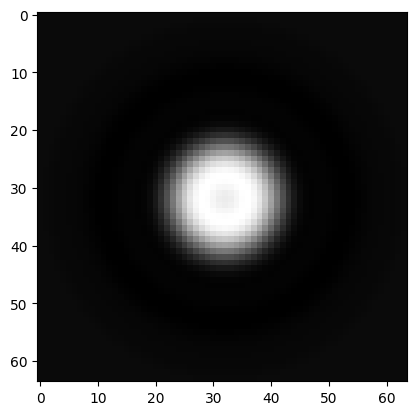

In [30]:
plt.imshow(temp_ri[32], cmap='gray')

In [31]:
#temp_ri = get_rotation_invariant_volume(fle, mat)

In [32]:
rot_ri = get_rotation_invariant_volume(fle, rot)

cc_ri = cross_correlation_3d(rot_ri, temp_ri)
loc_ri, amp_ri, _ = detect_peak_torch(cc_ri)

print("Standard CC:", loc_std, amp_std)
print("Rotation-Invariant CC:", loc_ri, amp_ri)

Standard CC: [ 0 19 27] 2.1516308786974037
Rotation-Invariant CC: [ 1.6204395  6.347796  31.513958 ] 1.5907522


## Rotational sweep

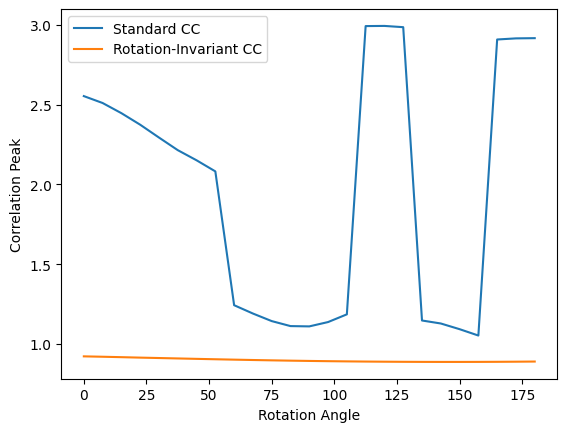

In [33]:
angles = np.linspace(0, 180, 25)
peaks_std = []
peaks_ri = []

for ang in angles:
    rotated = rotate(template, ang, axes=(1,2), reshape=False)

    cc = cross_correlation_3d(rotated, template)
    _, amp_std, _ = detect_peak_torch(cc, refine=False)
    peaks_std.append(amp_std)

    rotated_ri = get_rotation_invariant_volume(fle, rotated)
    cc2 = cross_correlation_3d(rotated_ri, temp_ri)
    _, amp_ri, _ = detect_peak_torch(cc2, refine=False)
    peaks_ri.append(amp_ri)

plt.plot(angles, peaks_std, label="Standard CC")
plt.plot(angles, peaks_ri, label="Rotation-Invariant CC")
plt.xlabel("Rotation Angle")
plt.ylabel("Correlation Peak")
plt.legend()
plt.show()

## Shrec dataset

In [34]:
def extract_patch(volume, center, size=64):
    """
    Extract a cubic patch of shape (size, size, size) around a given (z, y, x) center.
    """
    z, y, x = map(int, center)
    half = size // 2

    return volume[
        z-half : z+half,
        y-half : y+half,
        x-half : x+half
    ]

In [35]:
# import os
# print(os.path.getsize("/Users/sohamroy/Downloads/reconstruction.mrc"))

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


(512, 512, 512)
(array([    25,    258,   2882,  25750, 100725, 103596,  26466,   2334,
          103,      5]), array([-2.4152951 , -1.9337765 , -1.4522579 , -0.97073925, -0.48922062,
       -0.00770199,  0.47381663,  0.95533526,  1.4368539 ,  1.9183725 ,
        2.3998911 ], dtype=float32))


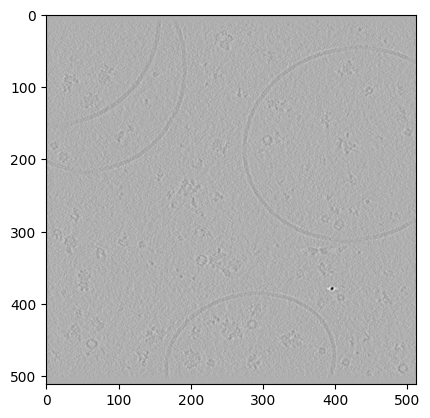

In [36]:
import mrcfile
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# with mrcfile.open("/Users/sohamroy/Downloads/reconstruction.mrc", permissive=True) as m:
with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    print(m.data.shape)
    plt.imshow(m.data[300],cmap="gray")
    print(np.histogram(m.data[256], bins=10))
    tomo = m.data.astype(np.float32)
    



In [37]:
tomo

array([[[ 0.04030928, -0.02602181, -0.02214897, ..., -0.04319197,
          0.01557835,  0.00593911],
        [-0.01271598,  0.00421418,  0.05841551, ...,  0.04124948,
         -0.00591481, -0.01566215],
        [-0.00769722, -0.00080364, -0.03190477, ...,  0.07048059,
         -0.00395592,  0.00090801],
        ...,
        [ 0.05035904, -0.04545299, -0.0324784 , ...,  0.0171659 ,
         -0.01074323,  0.01330657],
        [-0.0118594 ,  0.00324204, -0.01576201, ...,  0.02759492,
         -0.01103598, -0.01896342],
        [-0.02499172,  0.0029509 ,  0.03205818, ..., -0.02127624,
          0.01496664,  0.00136236]],

       [[ 0.03998695,  0.01144229, -0.0191135 , ..., -0.00988961,
          0.04220208, -0.02483092],
        [-0.02030083, -0.0315585 ,  0.02946287, ...,  0.02043258,
         -0.05392187,  0.02200961],
        [ 0.03364852, -0.04699063, -0.00351608, ...,  0.01028064,
         -0.02677718, -0.00409659],
        ...,
        [-0.00548871,  0.00456348, -0.02345988, ...,  

In [38]:
# particle_centers = np.loadtxt("/Users/sohamroy/Downloads/particle_locations.txt")
# template = extract_patch(tomo, particle_centers[0], size=64)

(512, 512, 512)


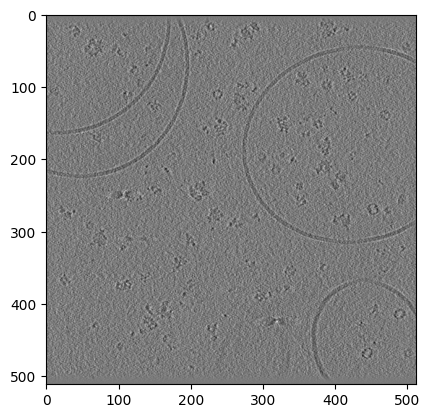

In [39]:
import mrcfile

import matplotlib.pyplot as plt
with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    print(m.data.shape)
    plt.imshow(m.data[230], cmap='gray')

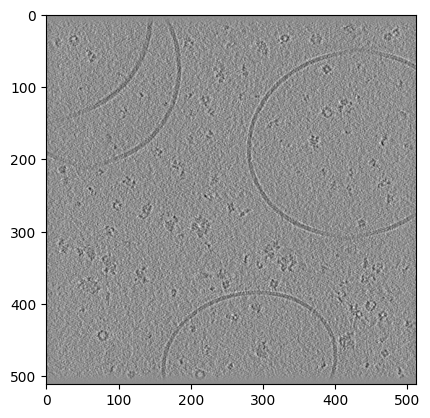

In [40]:
plt.imshow(tomo[320], cmap='gray')

In [41]:
import pandas as pd

gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)

gt.head()

,label,z,y,x,rot1,rot2,rot3
0,vesicle,425,180,95,NaN,NaN,NaN
1,vesicle,281,482,154,NaN,NaN,NaN
2,vesicle,15,10,86,NaN,NaN,NaN
3,vesicle,451,470,1,NaN,NaN,NaN
4,vesicle,43,64,74,NaN,NaN,NaN


In [42]:
print("Total GT objects:", len(gt))
print(gt["label"].value_counts())

Total GT objects: 1466
label
5MRC          131
1QVR          129
4CR2          119
4V94_fixed    118
1U6G          115
2CG9          112
3H84          111
3D2F          110
3QM1          108
1S3X          104
3GL1          104
3CF3          102
1BXN           88
fiducial       10
vesicle         5
Name: count, dtype: int64


# Computing CC across all peaks

In [43]:
import numpy as np
def safe_extract_patch(volume, center_zyx, size=64):
    z, y, x = map(int, center_zyx)
    h = size // 2
    if (z-h < 0 or y-h < 0 or x-h < 0 or
        z+h > volume.shape[0] or
        y+h > volume.shape[1] or
        x+h > volume.shape[2]):
        return None
    return volume[z-h:z+h, y-h:y+h, x-h:x+h]

In [44]:
def zscore(a, eps=1e-8):
    a = a.astype(np.float32, copy=False)
    m = a.mean()
    s = a.std()
    if s < eps:
        return None
    return (a - m) / s

def ncc_score(patch, template):
    """Normalized cross-correlation (dot product of z-scored arrays)."""
    p = zscore(patch)
    t = zscore(template)
    if p is None or t is None:
        return None
    return float(np.mean(p * t))

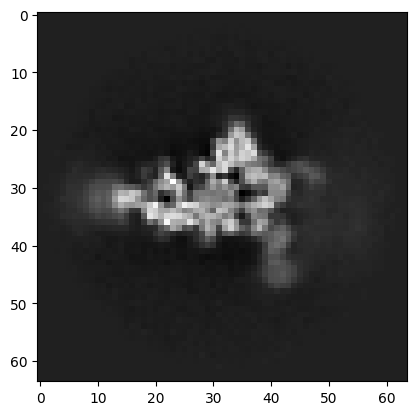

In [45]:
template_ri = get_rotation_invariant_volume(fle, template)
plt.imshow(template[32], cmap='gray')

In [46]:
def score_peaks_two_methods(tomo, peaks_zyx, template, template_ri, fle, patch_size=64):
    results = []
    for i, (z, y, x) in enumerate(peaks_zyx):
        patch = safe_extract_patch(tomo, (z, y, x), size=patch_size)
        if patch is None:
            continue

        # Method A: standard NCC
        score_std = ncc_score(patch, template)

        # Method B: RI NCC via FLE
        patch_ri = get_rotation_invariant_volume(fle, patch)
        score_ri = ncc_score(patch_ri, template_ri)

        results.append({
            "peak_id": i,
            "z": int(z), "y": int(y), "x": int(x),
            "score_std": score_std,
            "score_ri": score_ri
        })
    return results

In [47]:
def label_peaks_by_gt(peaks_zyx, gt_zyx, radius=6):
    gt = np.array(gt_zyx, dtype=np.float32)
    labels = np.zeros(len(peaks_zyx), dtype=int)

    for i, p in enumerate(peaks_zyx):
        d = np.sqrt(((gt - p)**2).sum(axis=1))
        if np.any(d <= radius):
            labels[i] = 1
    return labels  # 1=TP, 0=FP (rough)

In [48]:
gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)

In [49]:
#protein_labels = [
#     "1BXN", "1U6G", "3QM1", "1S3X",
#     "4V94_fixed", "4CR2", "2CG9", "3H84", "3D2F"
# ]

# gt_prot = gt[gt["label"].isin(protein_labels)]
gt_prot = gt[~gt["label"].isin(["vesicle", "fiducial"])] # only protein particles

In [50]:
#Build a reference template (protein only). Pick one protein instance (or later average multiple).
PATCH_SIZE = 64
template = None
template_center = None

Z, Y, X = tomo.shape
half = PATCH_SIZE // 2

def is_valid_center(z, y, x):
    return (
        z-half >= 0 and z+half < Z and
        y-half >= 0 and y+half < Y and
        x-half >= 0 and x+half < X
    )

for _, row in gt_prot.iterrows():
    z, y, x = int(row.z), int(row.y), int(row.x)
    if not is_valid_center(z, y, x):
        continue

    patch = safe_extract_patch(tomo, (z, y, x), size=PATCH_SIZE)
    if patch is not None:
        template = patch
        template_center = (z, y, x)
        break

assert template is not None, "No valid GT protein template found"



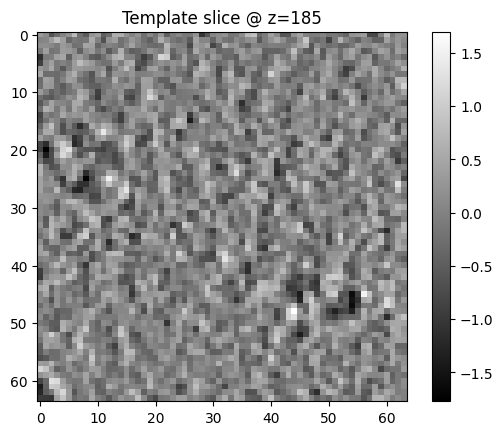

In [51]:
plt.imshow(template[PATCH_SIZE//2], cmap="gray")
plt.title(f"Template slice @ z={template_center[0]}")
plt.colorbar()
plt.show()
template_ri = get_rotation_invariant_volume(fle, template)

In [52]:
template_ri = get_rotation_invariant_volume(fle, template)

In [53]:
# Detect peaks from standard NCC volume
_, _, peaks_zyx = detect_peak_torch(
    cc_std,
    min_distance=2,
    threshold_abs=0.01,
    refine=False
)

peaks_zyx = peaks_zyx.astype(int)

print("Detected peaks:", peaks_zyx.shape[0])
print(peaks_zyx[:5])

Detected peaks: 13
[[ 0 19 27]
 [ 0 35  0]
 [ 0 46 36]
 [11  0 32]
 [30 30  0]]


In [54]:
PATCH_SIZE = 64
half = PATCH_SIZE // 2
Z, Y, X = tomo.shape

def valid_peak(p):
    z, y, x = p
    return (
        z-half >= 0 and z+half < Z and
        y-half >= 0 and y+half < Y and
        x-half >= 0 and x+half < X
    )

peaks_zyx = np.array([p for p in peaks_zyx if valid_peak(p)])

print("Valid peaks after filtering:", len(peaks_zyx))

Valid peaks after filtering: 1


In [55]:
results = score_peaks_two_methods(
    tomo,
    peaks_zyx,
    template,
    template_ri,
    fle,
    patch_size=PATCH_SIZE
)

In [56]:
df = pd.DataFrame(results)
df.head()

,peak_id,z,y,x,score_std,score_ri
0,0,63,46,37,0.002679,-0.086426


In [57]:
df

,peak_id,z,y,x,score_std,score_ri
0,0,63,46,37,0.002679,-0.086426


In [58]:
print("Number of scored peaks:", len(df))
print("STD score range:", df.score_std.min(), df.score_std.max())
print("RI  score range:", df.score_ri.min(), df.score_ri.max())

Number of scored peaks: 1
STD score range: 0.002679073018953204 0.002679073018953204
RI  score range: -0.08642620593309402 -0.08642620593309402


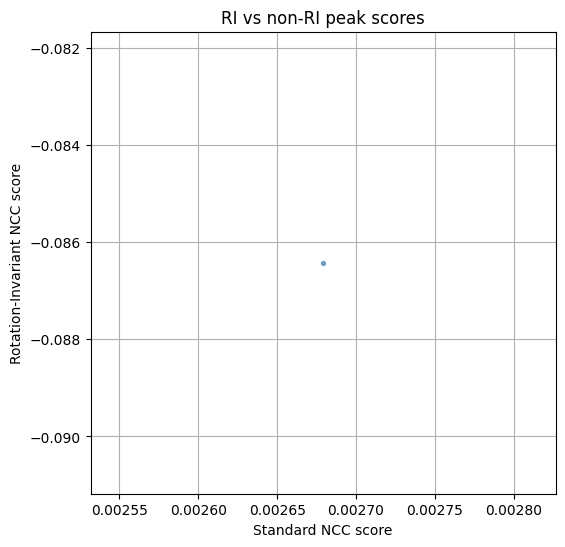

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df.score_std, df.score_ri, s=8, alpha=0.6)
plt.xlabel("Standard NCC score")
plt.ylabel("Rotation-Invariant NCC score")
plt.title("RI vs non-RI peak scores")
plt.grid(True)
plt.show()

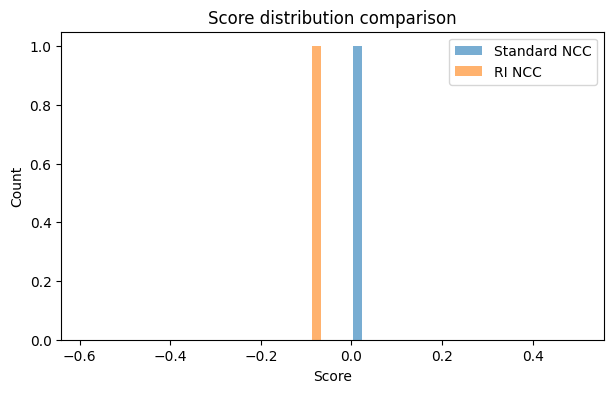

In [60]:
plt.figure(figsize=(7,4))
plt.hist(df.score_std, bins=50, alpha=0.6, label="Standard NCC")
plt.hist(df.score_ri, bins=50, alpha=0.6, label="RI NCC")
plt.legend()
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution comparison")
plt.show()

In [61]:
df["rank_std"] = df.score_std.rank(ascending=False)
df["rank_ri"]  = df.score_ri.rank(ascending=False)

df[["peak_id", "rank_std", "rank_ri"]].head()
rank_diff = (df.rank_std - df.rank_ri).abs()

print("Mean |rank_std - rank_ri|:", rank_diff.mean())
print("Max  |rank_std - rank_ri|:", rank_diff.max())

Mean |rank_std - rank_ri|: 0.0
Max  |rank_std - rank_ri|: 0.0


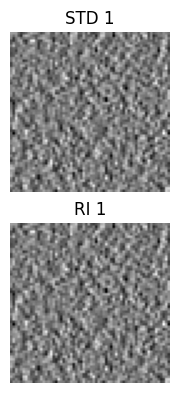

In [62]:
TOPK = 5

top_std = df.sort_values("score_std", ascending=False).head(TOPK)
top_ri  = df.sort_values("score_ri",  ascending=False).head(TOPK)
def show_peak(tomo, row, title):
    patch = safe_extract_patch(tomo, (row.z, row.y, row.x), size=64)
    plt.imshow(patch[32], cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,4))
for i, (_, r) in enumerate(top_std.iterrows()):
    plt.subplot(2, TOPK, i+1)
    show_peak(tomo, r, f"STD {i+1}")

for i, (_, r) in enumerate(top_ri.iterrows()):
    plt.subplot(2, TOPK, TOPK+i+1)
    show_peak(tomo, r, f"RI {i+1}")

plt.tight_layout()
plt.show()

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


Template shape: (33, 33, 33)


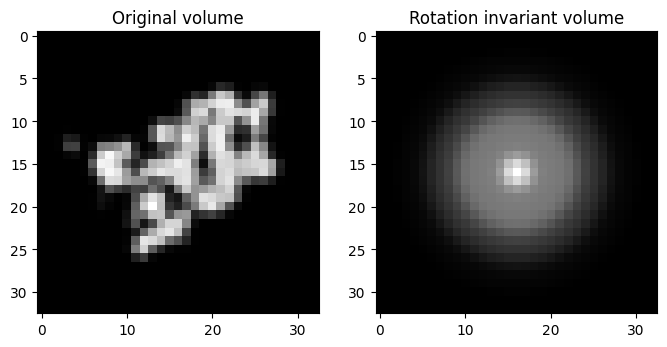

(16, 16, 16)


: 

In [ ]:
# import particle
# I recommend to go for one of (4CR2, 5MRC,4V94). They are the largest proteins in the dataset
template = mrcfile.open("4CR2_10.00A_solvent-4.530V_real.mrc", permissive=True).data
print("Template shape:", template.shape)
from fle_3d import FLEBasis3D
fle = FLEBasis3D(
    N = template.shape[0],
    bandlimit = 32,
    eps = 1e-4)

# rotation invariant template
template_ri = get_rotation_invariant_volume(fle, template)

# View central slices
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(template[template.shape[0]//2], cmap='gray')
axs[0].set_title('Original volume')
axs[1].imshow(template_ri[template_ri.shape[0]//2], cmap='gray')
axs[1].set_title('Rotation invariant volume')
plt.show()

print(np.unravel_index(np.argmax(template_ri), template.shape))




In [ ]:
# Load tomogram
tomo = mrcfile.open("reconstruction.mrc", permissive=True).data.copy()
grand_model = mrcfile.open("grandmodel.mrc", permissive=True).data.copy()

# Print shapes
print("Tomogram shape:", tomo.shape)
print("Template shape:", template.shape, template_ri.shape)


def compute_cc(vol, ref):
    
    if ref.shape != vol.shape:
        # Apply zero-padding to the smaller volume
        max_shape = np.maximum(ref.shape, vol.shape)
        ref_padded = np.zeros(max_shape, dtype=ref.dtype)
        vol_padded = np.zeros(max_shape, dtype=vol.dtype)
        ref_padded[:ref.shape[0], :ref.shape[1], :ref.shape[2]] = ref
        vol_padded[:vol.shape[0], :vol.shape[1], :vol.shape[2]] = vol
        ref, vol = ref_padded, vol_padded
    assert ref.shape == vol.shape, "Volumes must have the same shape after padding."
    print("Computing CC for volumes of shape:", ref.shape)

    F1 = np.fft.fftn(ref)
    F2 = np.fft.fftn(vol)
    cc = np.fft.ifftn(F2 * np.conj(F1))
    cc= np.real(cc)
    return cc , ref

# Expect this to take some time
# For large tomograms, consider using GPU-acceleration through PyTorch
# Or use sub-volumes

# For now, look at grand_model only
cc, ref_padded = compute_cc(grand_model, template)

cc_ri, ref_padded_ri = compute_cc(grand_model, template_ri)




/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


Tomogram shape: (512, 512, 512)
Template shape: (33, 33, 33) (33, 33, 33)
Computing CC for volumes of shape: (180, 512, 512)


In [ ]:
# Consider only positive CC values for peak detection
cc_ri_pos = np.maximum(cc_ri, 0)
cc_pos = np.maximum(cc, 0)

peaks = find_peaks_3d(
        cc_pos,
        min_distance=1, 
        threshold_abs=0.01,
        return_as="torch")
peaks_ri = find_peaks_3d(
        cc_ri_pos,
        min_distance=1,
        threshold_abs=0.01,
        return_as="torch")

In [ ]:
# Look at ten highest peaks from both methods
TOPK = 50
top_std = peaks[0][peaks[1].argsort(descending=True)[:TOPK]] + 16 # is size of template,shape[0] //2

print(cc_ri_pos.shape)
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]] + 16 # is size of template,shape[0] //2

print("Top peaks (ri):", top_ri)

print("scores (ri):", peaks_ri[1][peaks_ri[1].argsort(descending=True)[:TOPK]])


(180, 512, 512)
Top peaks (ri): tensor([[ 87, 429, 368],
        [131, 164, 112],
        [ 16, 135, 334],
        [195, 135, 334],
        [ 95, 277,  45],
        [163, 105, 158],
        [ 29, 205,  48],
        [ 58,  47, 178],
        [ 98, 441, 424],
        [125, 322,  93],
        [134, 455,  31],
        [116, 286, 222],
        [ 72, 408, 193],
        [ 70, 263, 219],
        [ 89, 461,  26],
        [ 50, 452, 171],
        [ 29,  37, 190],
        [111, 302, 243],
        [146, 329, 264],
        [ 36,  81,  47],
        [123, 119, 423],
        [ 29, 316, 373],
        [146, 486, 250],
        [ 78, 432, 137],
        [ 62, 472, 235],
        [ 72, 226, 199],
        [154, 480, 155],
        [ 23, 214, 299],
        [131, 198, 176],
        [113, 334, 283],
        [ 72,  38, 164],
        [ 81, 297, 263],
        [ 19, 203, 421],
        [ 68, 461, 440],
        [ 53, 240, 433],
        [130, 116, 314],
        [ 98, 210, 393],
        [ 19,  20,  69],
        [ 95, 160,

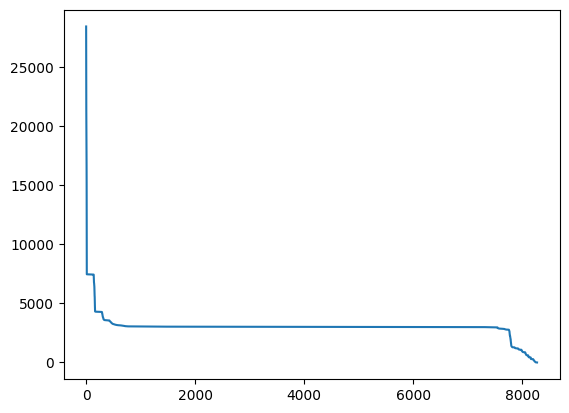

Dot product with RI template and score_rank 40: 7459.620710063286 vs 7459.618979207675


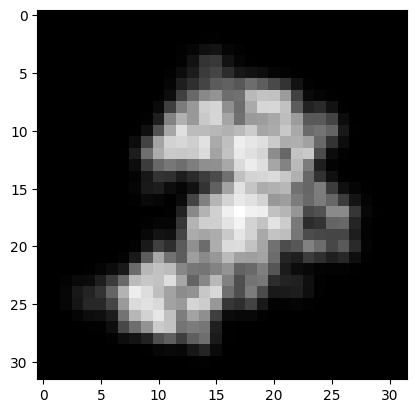

Dot product with STD template and score_rank 40: 8402.263671875 vs 8402.2626953125


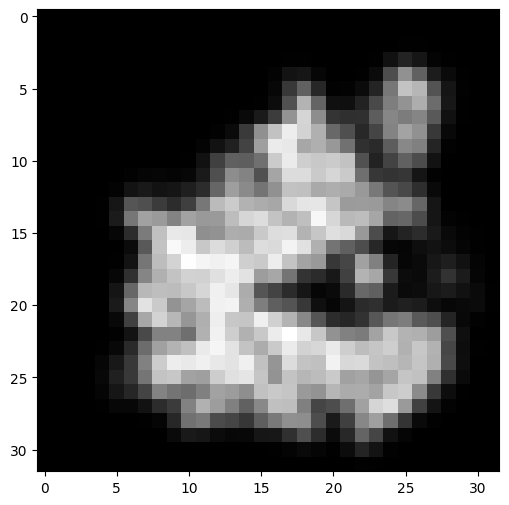

In [ ]:
def extract_patch(volume, center, size=64):
    """
    Extract a cubic patch of shape (size, size, size) around a given (z, y, x) center.
    """
    z, y, x = map(int, center)
    half = size // 2

    return volume[
        z-half : z+half,
        y-half : y+half,
        x-half : x+half
    ]


# First ranks are dominated by fiducial markers: look at the scores
plt.plot(peaks_ri[1][peaks_ri[1].argsort(descending=True)], label='RI scores')
plt.show()


# Select one of the mid-ranked peaks and extract patch
score_rank = 40

patch = extract_patch(grand_model, ( top_ri[score_rank]), size=32)

plt.imshow(patch[16], cmap='gray')
dot = np.sum(patch * template_ri[:-1, :-1, :-1])
# This is correct if its very close (like one decimal)
print(f"Dot product with RI template and score_rank {score_rank}: {dot} vs {peaks_ri[1][peaks_ri[1].argsort(descending=True)[score_rank]]}")
plt.show()

plt.figure(figsize=(6,6))
patch_std = extract_patch(grand_model, ( top_std[score_rank]), size=32)
plt.imshow(patch_std[16], cmap='gray')
dot_std = np.sum(patch_std * template[:-1, :-1, :-1])
print(f"Dot product with STD template and score_rank {score_rank}: {dot_std} vs {peaks[1][peaks[1].argsort(descending=True)[score_rank]]}")
plt.show()



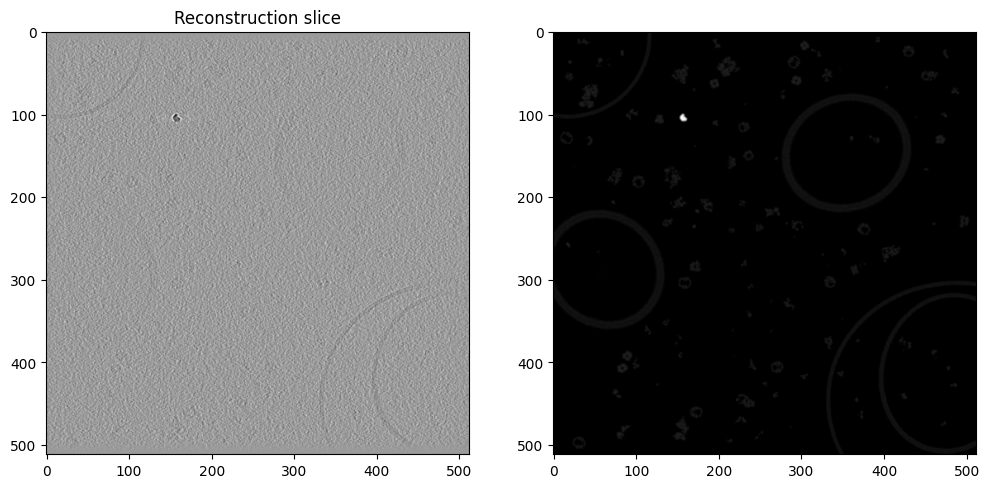

In [ ]:
rec = mrcfile.open("reconstruction.mrc", permissive=True).data
grand_model = mrcfile.open("grandmodel.mrc", permissive=True).data

id =160
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(rec[166+id], cmap='gray')
ax[0].set_title("Reconstruction slice")
ax[1].imshow(grand_model[0+id], cmap='gray')

# difference is something like 166 in the first coordinate!!

# more or less we have:
# reconstruction[166:166+180, :, :] = grand_model[:, :, :] + noise and missing wedge artifacts

# 166 comes from: (512-180)/2 = 166

